# Imports and Setting up Plotting

In [3]:
from datetime import date, timedelta
import os
import glob

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

rcParams = {'figure.max_open_warning': 0,
            'figure.figsize': (15, 8),
            'axes.grid': True}

plt.rcParams.update(rcParams)
plt.style.use('bmh')

pd.options.display.max_rows = 50

# Loading Data

In [4]:
# Reading CSV files and Loading the data
filepath = r'./data/*.csv'
csv_files = glob.glob(filepath)

data = {}

for csv_file in csv_files:
    print('Loading ', csv_file)
    data_key = csv_file.rsplit('/', 1)[-1].split('.')[0]    
    df = pd.read_csv(csv_file)
    df.set_index('dates', inplace=True)
    df.index = pd.to_datetime(df.index)
    data[data_key] = df
    
asset_prices = data['asset_prices']

# Firstly Grab the data by country
countries = ['US', 'CA']
data_labels = ['Unemployment', 'IndustrialProduction', 'GDP', 'HomeSales']

economic_data = {}

for country in countries:
    tmp_data = {}

    for label in data_labels:
        tmp_data[f'{label}'] = data[f'{country}_{label}']

    economic_data[f'{country}'] = tmp_data

Loading  ./data/CA_Unemployment.csv
Loading  ./data/CA_IndustrialProduction.csv
Loading  ./data/US_Unemployment.csv
Loading  ./data/US_HomeSales.csv
Loading  ./data/asset_prices.csv
Loading  ./data/US_IndustrialProduction.csv
Loading  ./data/US_GDP.csv
Loading  ./data/CA_GDP.csv
Loading  ./data/CA_HomeSales.csv


## Examining Data

In [5]:
asset_prices

,ES1 Index,PT1 Index,CADUSD Curncy,DXY Curncy
dates,,,,
1980-01-01,NaN,NaN,0.8559,85.820
1980-01-02,NaN,NaN,0.8578,85.320
1980-01-03,NaN,NaN,0.8545,85.260
1980-01-04,NaN,NaN,0.8557,85.230
1980-01-07,NaN,NaN,0.8551,84.790
...,...,...,...,...
2023-01-20,3988.50,1237.2,0.7474,102.012
2023-01-23,4036.50,1244.9,0.7481,102.138
2023-01-24,4032.75,1244.1,0.7480,101.918


In [6]:
economic_data

{'US': {'Unemployment':             actual_value  expected_value  number_of_forecaster
  dates                                                         
  1997-02-07           5.4             5.3                   0.0
  1997-03-07           5.3             5.3                   0.0
  1997-04-04           5.2             5.2                   0.0
  1997-05-02           4.9             5.2                   0.0
  1997-06-06           4.8             5.0                   0.0
  ...                  ...             ...                   ...
  2022-05-06           3.6             3.5                  76.0
  2022-06-03           3.6             3.5                  69.0
  2022-07-08           3.6             3.6                  74.0
  2022-08-05           3.5             3.6                  71.0
  2022-09-02           3.7             3.5                  71.0
  
  [307 rows x 3 columns],
  'IndustrialProduction':             actual_value  expected_value  number_of_forecaster
  dates        

# Building An Indicator

In this example, we assume that the growth rate of GDP is a good indication of the growth of a country's economy. For illustrative and simplicity reasons, we will focus on only this data. With this assumption, again for simplicity, we propose our indicator as just the actual value of GDP growth rate.

In [7]:
us_gdp = economic_data['US']['GDP']['actual_value']  # US GDP growth rate
ca_gdp = economic_data['CA']['GDP']['actual_value']  # Canada GDP growth rate

gdp = pd.concat([us_gdp, ca_gdp], axis=1, sort=True, keys=['US', 'CA'])

In [8]:
# our economic indicator is just the GDP growth rate
ca_indicator = ca_gdp
us_indicator = us_gdp

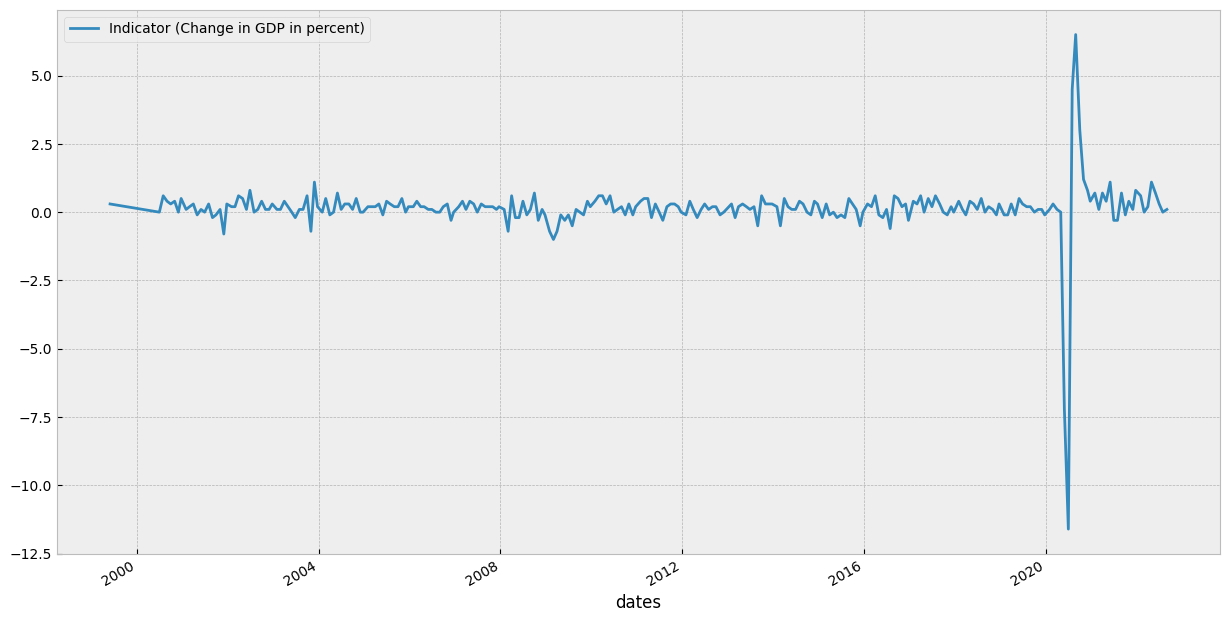

In [9]:
ca_indicator.plot(label='Indicator (Change in GDP in percent)')
plt.legend()

# Building a Trading Signal Using the Indicator

Using the indicator that we have created, we then try to create a trading signal.

We start by thinking how we can trade this strategy.

The most simplistic use of the indicator to trade would be using the indicator as the trading signal without any transformation. In our example, that would mean buy (go long) when the change in GDP is positive, and sell (go short) when the change in GDP is negative. This approach is shown in basic_signal() below.

We encourage you to try some new signals. As an example of how a signal might look like, you can look at the momentum trading signal in the Software Engineering project (Project 1).

In [10]:
def basic_signal(ts):
    # ts is a vector
    signal = pd.DataFrame(np.zeros((len(ts.index), 1)),index=ts.index, columns=['signal'])
    signal[ts > 0] = 1
    signal[ts < 0] = -1
    
    return signal

In [11]:
ca_sgnl = basic_signal(ca_gdp)
us_sgnl = basic_signal(us_gdp)

## Show Performance of the Trading Signal

### Choose the assets you want to trade

In [12]:
# In this case, we are postulating that when the change in GDP is positive,
# both the country's stock market and the country's currency will rise.
ca_assets = ['PT1 Index', 'CADUSD Curncy']
us_assets = ['ES1 Index', 'DXY Curncy']

### Calculate PnL

In [13]:
def calculate_pnl(ret, pos):
    # function to calculate profit and loss
    # we trade at the end of the period, and take profit & loss on the market move next period on our position
    # that's why we are shifting positon vector by one
    return ret.multiply(pos.shift(), axis=0).dropna()

In [14]:
# build the return series for each of the series
ca_returns = asset_prices[ca_assets].pct_change()
us_returns = asset_prices[us_assets].pct_change()

# Resample the Signal into daily signal
ca_daily_pos = ca_sgnl.resample('D').ffill()
us_daily_pos = us_sgnl.resample('D').ffill()

In [15]:
us_pnl = calculate_pnl(us_returns, us_daily_pos['signal'])
ca_pnl = calculate_pnl(ca_returns, us_daily_pos['signal'])

<Axes: title={'center': 'Cumulative Trading Profit'}, xlabel='dates'>

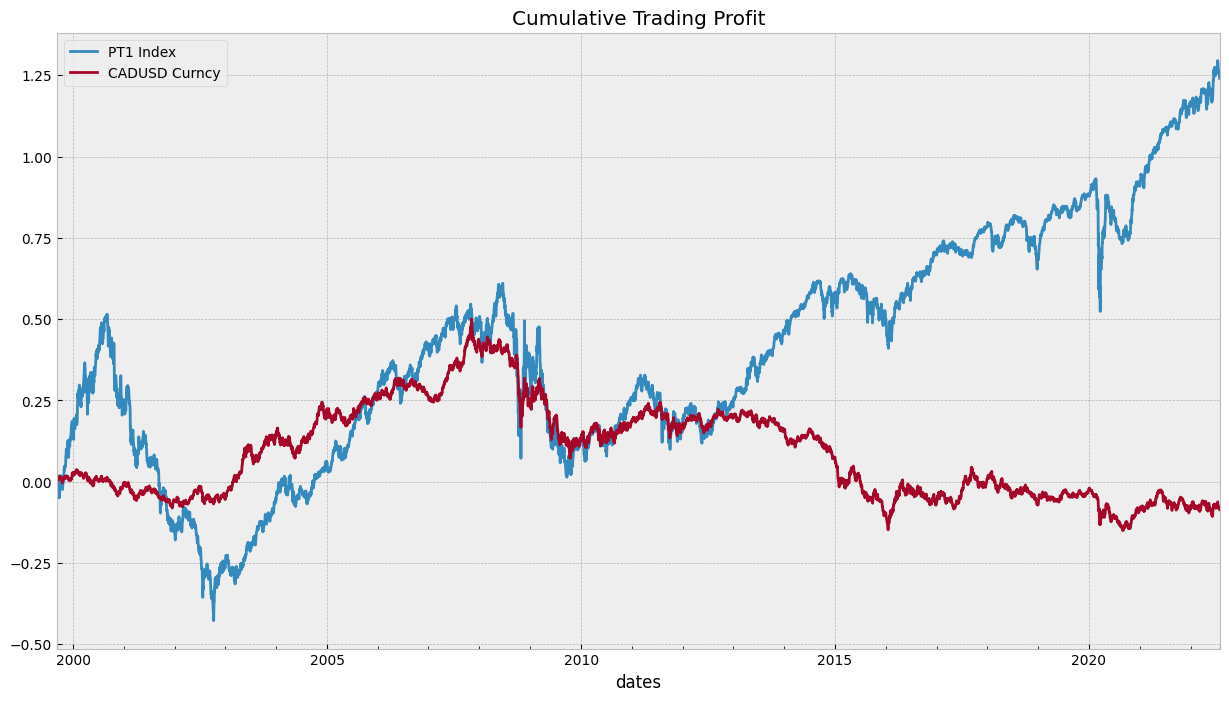

In [16]:
ca_pnl.cumsum().plot(title='Cumulative Trading Profit')

<Axes: title={'center': 'Cumulative Trading Profit'}, xlabel='dates'>

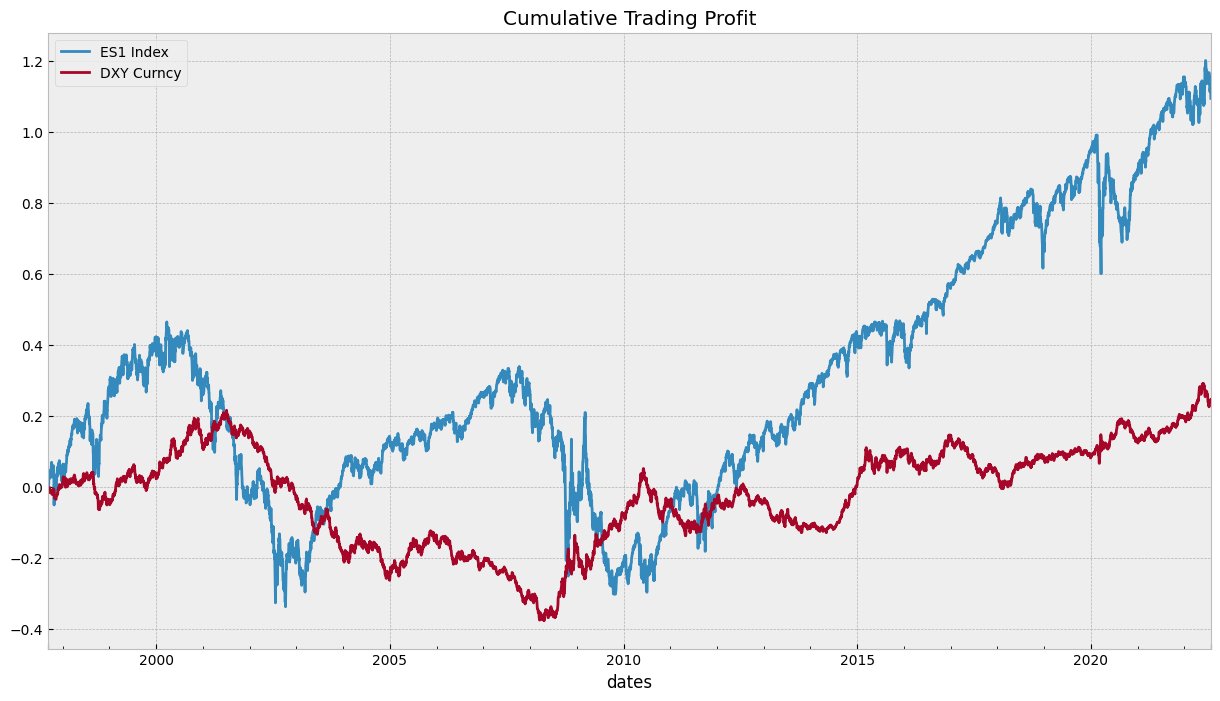

In [17]:
us_pnl.cumsum().plot(title='Cumulative Trading Profit')

## Some thoughts on the performance of the trading signal

Please examine the results of your trading signal and provide some commentary on the performance. 

If it performs well. Why? If it doesn't, why not? How can you make it better? 

What would be the next steps, if on the job, you are asked to further explore this investigation?

--- 

My thoughts on the above questions:

Observations for ES1 and PT1:
* Signal does well on ES1 and PT1.
* Majority of the performance comes after 2010.
* The signal has massive drawdowns, that is, when the signal does bad, it does really bad.
* Bad performance by this signal is concentrated 5-7 years when the economy was doing bad as well (Tech-bubble burst; 2008 crisis).

Observations for currencies:
* The signal does poorly on currencies (remaining mostly flat).
* Good and bad performances range approximately half the time period each (about ~10 years each). Good performance does not overperform the bad performacne.

We know that the US and Canada economy did really well post 2008 crisis and we also had a major bull run in the same period. These two factors combined can explain the positive performance that we see for the signal for ES1 and PT1.

The signal right now can take the value of either 1 or -1. One way to make the signal better will be to overlay this signal with momentum. There are many reasons why this can make the signal better:
* Allow continuous values between -1 and 1. 
* Allows the signal to be 0, or close to 0 during low conviction periods.
* The signal is fully long/short when it has enough evidence of doing so (put another way, the lookback period in the momentum indicates so).
* This will maintain the positive performance post 2008 crisis, and can possibly reduce the drawdowns pre crisis.
* It is to be noted that momentum is an ex-post signal and doesn't perform as well when the market is moving sideways.

One of the next steps will be to explore the performance of this signal with other metrics such as IR, drawdowns, etc. Long vs Short performance will provide more insights on this signal. An important question to explore is what are the turnover costs? Since we can go from -1 to 1 (and vica versa), the turnover costs can really impact the profitability of the strategy. Another important step will be to test how well this signal integrates with the other signals already implemented. Does it provide more value or not? If it does add value, what should be its ideal weight in the portfolio of signals? How should these signals be aggregated? Are there periods where this signal performs good/bad and can these periods be categorized by other indicators?

# Economic Indicator

## Intuition behind the economic indicators: 
The 4 economic indicators provided can all indicate the future performance of the financial markets. In general:
* `GDP growth rate (%)` is expected to be proportional to the financial market returns. Strong GDP growth rate indicates a strong economy.
* `Industrial Production` is expected to be proportional to the financial market returns. Strong Production data indicates that the demand is strong in the economy.
* `Home Sales` data is also expected to be proportional to the finnacial market returns. In general, if people have the money to buy new houses, they have the money to create demand in the economy for other products and services, which is indicative of a strong economy.
* `Unemployment rate` is expected to be inversely proportional the financial market returns. Lower unployment rates are indicative of a strong economy.

## Thoughts / Ideas

### Idea 1: Intuition -> strategy
We can use the above intuition to formulate a simple indicator. Process each indicator separately and get a +/-1 signal as in the example. Then combine them together using a mean/max of the four values. Instead of using +/-1 as signals, we can calculate a rolling mean for these indicators, which will indicate the health of the economy in the rolling period. Then we can research the profitability if trade in direction of this indicator and/or we can research how the market performs when the current point (maybe expected, maybe actual) challenges the momentum so far.
### Idea 2: Shocks
Tail events guide majority of financial market movements. Investigating the expected vs actual shocks can be an interesting area of research. Further research into this topic can allow us to explore the notion of "Meeting the expectation is the same as missing the expectation". 
### Idea 3: cross-setional
US and Canadian economies are very inter-linked. One indicator of the US economy can sometimes be a leading indicator of Canada's economy as well, and vica versa. Additionally, this may also lead to interesting cases where the same indicator for both the countries are indicating different things which can lead to potential research avenue.

## Conclusion
Due to limited time, I'll focus on only one of the ideas above. I choose Idea 2 mainly becuase of personal interest.

NOTE: In real life analysis, I would investigate the hypothesis further before deciding on a potential area of research. 

## Exploring Idea 2: Expected vs Actual Shocks

In [18]:
economic_data['US']['GDP']

,actual_value,expected_value,number_of_forecaster
dates,,,
1997-04-30,5.6,4.2,2.0
1998-04-30,4.2,3.4,19.0
1998-07-31,1.4,0.4,51.0
1998-10-30,3.3,2.3,67.0
1999-01-29,5.6,4.4,37.0
...,...,...,...
2021-07-29,6.5,8.4,69.0
2021-10-28,2.0,2.6,70.0
2022-01-27,6.9,5.5,69.0


In [19]:
economic_data['US']['HomeSales']

,actual_value,expected_value,number_of_forecaster
dates,,,
2005-06-01,3.6,1.00,3.0
2005-07-06,-2.0,0.50,5.0
2005-08-01,0.6,0.80,5.0
2005-09-01,-1.0,0.00,5.0
2005-10-05,3.2,-0.50,7.0
...,...,...,...
2022-04-27,-1.2,-1.00,23.0
2022-05-26,-3.9,-2.10,26.0
2022-06-27,0.7,-4.00,20.0


In [20]:
economic_data['US']['IndustrialProduction']

,actual_value,expected_value,number_of_forecaster
dates,,,
1997-02-14,0.0,0.2,0.0
1997-03-14,0.5,0.5,0.0
1997-04-16,0.9,0.6,0.0
1997-05-15,0.0,0.1,0.0
1997-06-17,0.4,0.3,0.0
...,...,...,...
2022-04-15,0.9,0.4,65.0
2022-05-17,1.1,0.5,65.0
2022-06-17,0.2,0.4,65.0


In [21]:
economic_data['US']['Unemployment']

,actual_value,expected_value,number_of_forecaster
dates,,,
1997-02-07,5.4,5.3,0.0
1997-03-07,5.3,5.3,0.0
1997-04-04,5.2,5.2,0.0
1997-05-02,4.9,5.2,0.0
1997-06-06,4.8,5.0,0.0
...,...,...,...
2022-05-06,3.6,3.5,76.0
2022-06-03,3.6,3.5,69.0
2022-07-08,3.6,3.6,74.0


### Calculate shock percentate

* shock percentate = (actual - expected) / expected

A positive shock here will be indicative of a positive reaction of the market.

In [22]:
# Add this value to the provided dictionary - economic_data

for country, country_data in economic_data.items():
    for indicator, indicator_data in country_data.items():
        indicator_data[indicator+'_shock'] = (indicator_data['actual_value'] / indicator_data['expected_value']) - 1.
        if indicator == "Unemployment": 
            indicator_data[indicator+'_shock'] = -1 * indicator_data[indicator+'_shock']            # Logic for this is highlighted in the intuition above.

### Explore distribtion of shock %

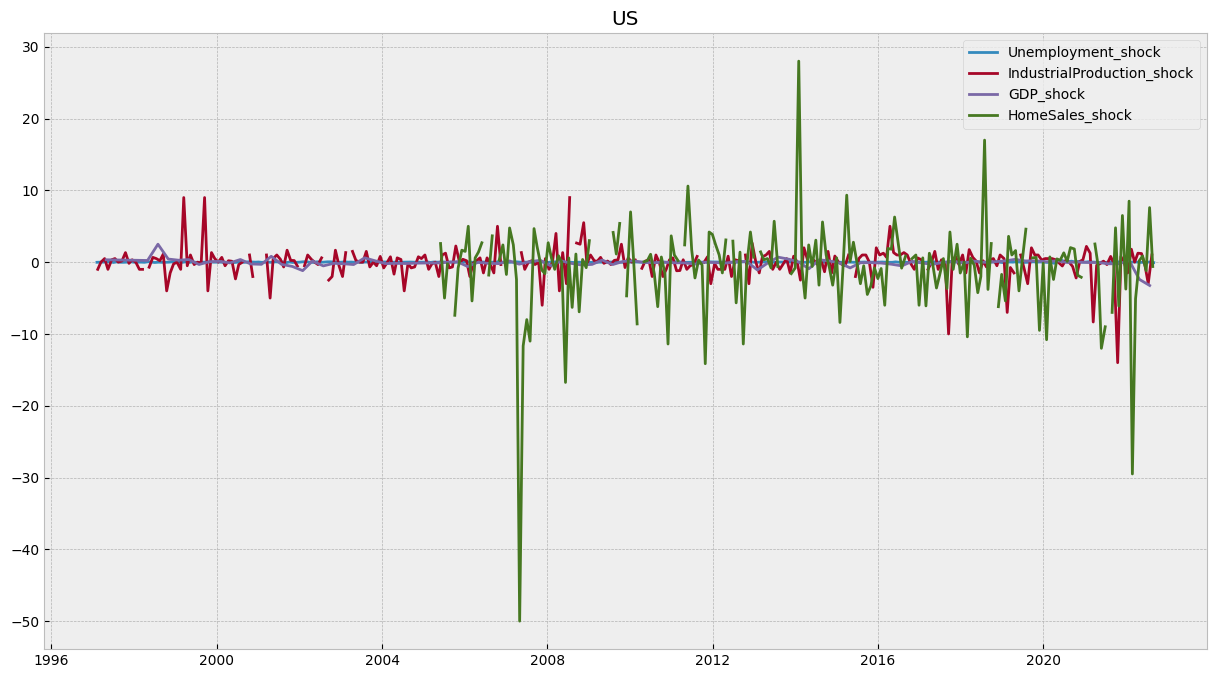

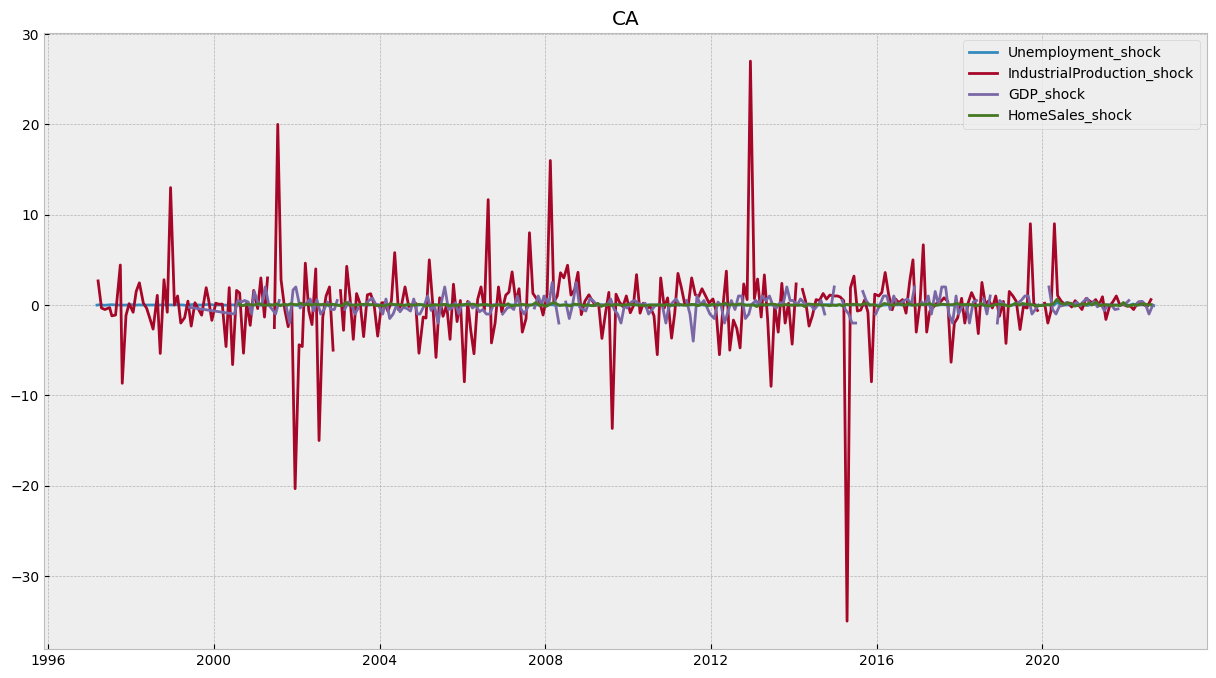

In [23]:
for country, country_data in economic_data.items():
    plt.figure()
    for indicator, indicator_data in country_data.items():
        plt.plot(indicator_data[indicator+'_shock'], label=indicator+'_shock')
    plt.title(country)
    plt.legend()
    plt.show()

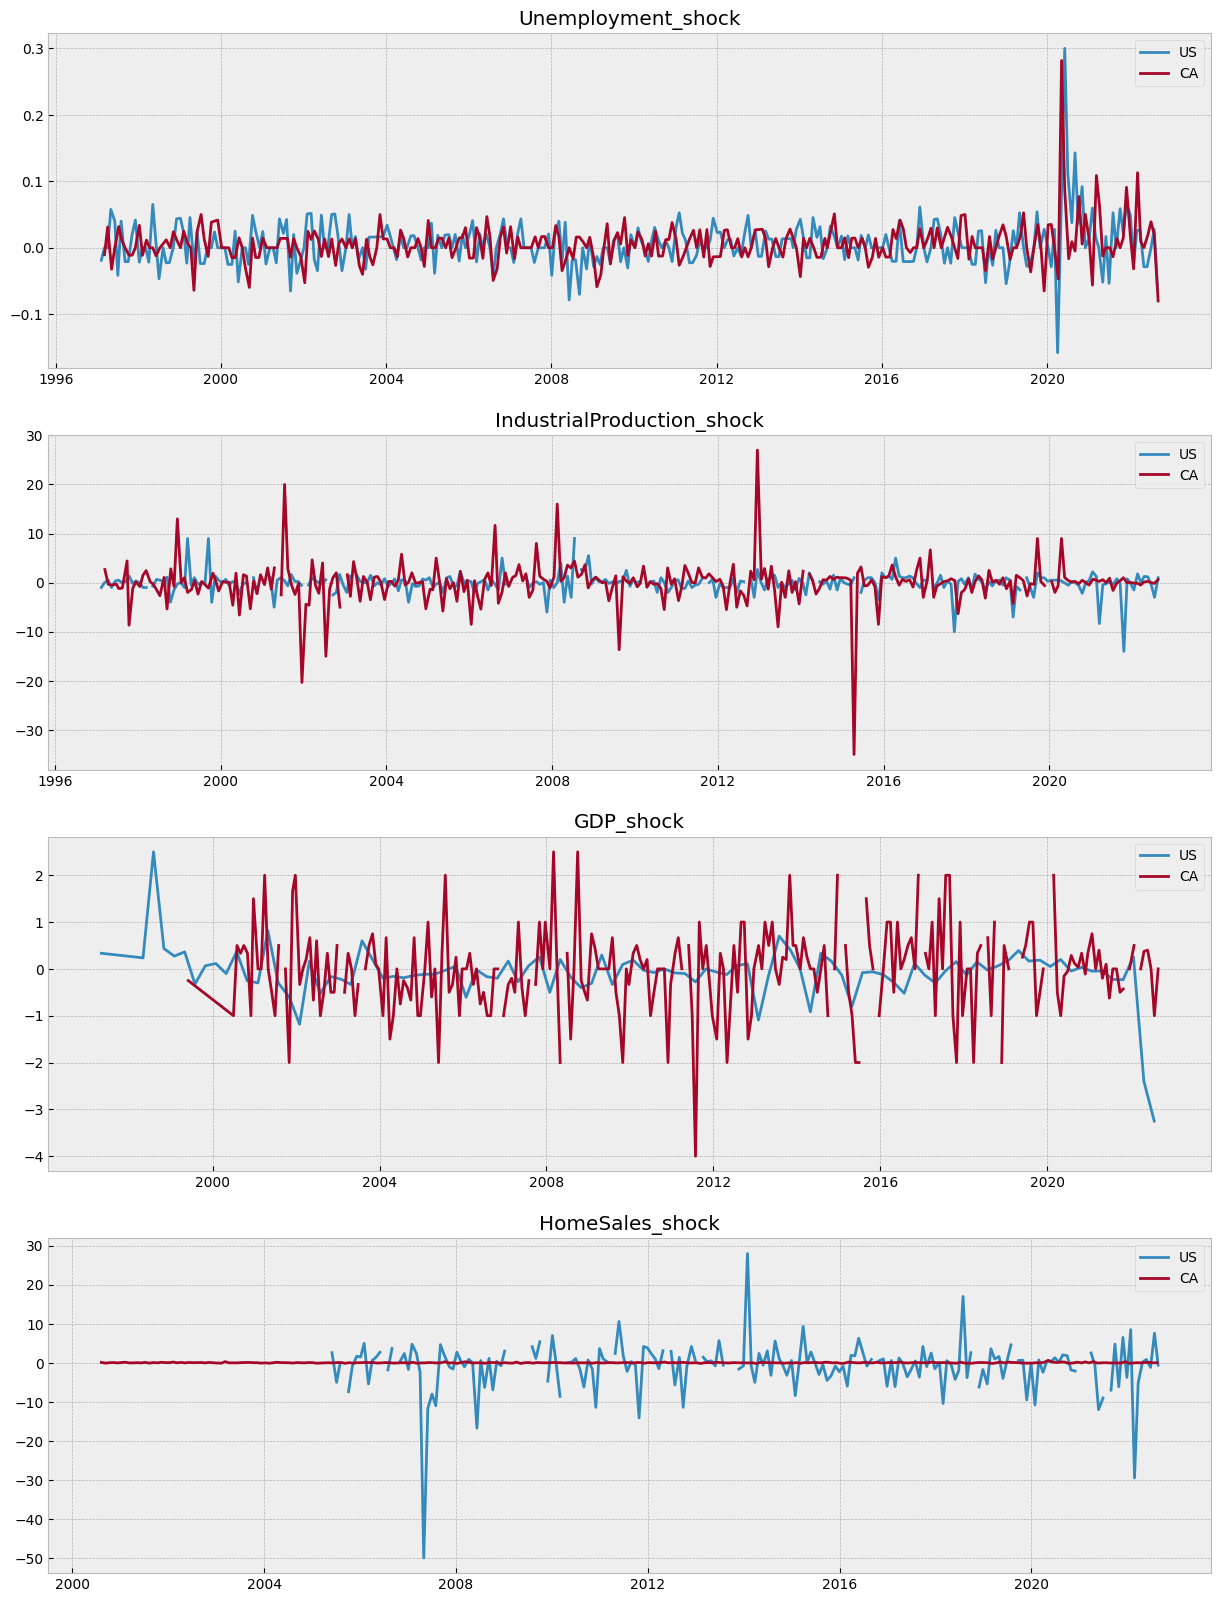

In [24]:
fog, axes = plt.subplots(4, 1, figsize=(15, 20))

for i, indicator in enumerate(economic_data['US'].keys()):
    for country, country_data in economic_data.items():
        axes[i].plot(country_data[indicator][indicator+'_shock'], label=country)
    axes[i].set_title(indicator+'_shock')
    axes[i].legend()
plt.show()


As we can see, for different countries, different economic indicators are more volatile than the others. Here are some observations (just by visual inspection; in real life, I would have come up with metrics to support the following):
* Unemployment for both countries behave similarly.
* Industrial Production in Canada has more shocks than the US data. Canadian data here appears to be more volatile.
* Canada GDP shocks data is more volatile than US GDP shocks.
* US Home Sales shocks data is more volatile than Canada Home Sales shocks.

Volatility, or major differences in Expected Value vs Actual Value, might not always be motivated by economic factors. Difference in skill level between the 2 countries to estimate different kinds of data will also lead to major differences.

Hence, for our economic indicator, we need to scale these by volatility.

## 'Shocks' Economic Indicator Creation

Construction formula:
- Calculate Shocks using: (actual - expected) / expected   ...     [negative for Unemployment]
- Scale each shock value to unit vol, i.e., divide by volatility    ...     [use rolling volatility]
- Aggregate all 4 shocks values using the equal-weighted approach.

Note that each of the 4 indicators have different frequencies and/or different dates when they are reported.

To make the analysis easy, we recalculate the `shock` indicator whenever we come across new value. For the rest of the indicators, their previous available data is used. We start calclating this economic signal when all 4 data points is available. 

`Then, this indicator tells us how 'unexpected' of a state the current economy is in.`

In [25]:
# Create economic indicator from shock values
shocks_agg = {}

for country, country_data in economic_data.items():
    frames = []
    for indicator, indicator_data in country_data.items():
        frames.append( indicator_data[indicator+'_shock'] )
    
    df = pd.concat( frames, axis=1, ignore_index=False )
    df.ffill(inplace=True)
    df.dropna(axis=0, how='any', inplace=True)
    df = df / df.rolling(window=40).std()       # 3 observations / month + 1 observation / quarter ==> 10 observations / quarter ==> 40 observations per year (approx)
    shocks_agg[country] = np.mean(df, axis=1)

In [26]:
shocks_agg

{'US': dates
 2005-06-01         NaN
 2005-06-03         NaN
 2005-06-15         NaN
 2005-07-06         NaN
 2005-07-08         NaN
                 ...   
 2022-07-28   -1.220828
 2022-08-05   -0.896447
 2022-08-16   -0.500878
 2022-08-24   -0.463026
 2022-09-02   -0.990565
 Length: 677, dtype: float64,
 'CA': dates
 2000-08-09         NaN
 2000-08-16         NaN
 2000-08-31         NaN
 2000-09-08         NaN
 2000-09-11         NaN
                 ...   
 2022-08-05    0.024039
 2022-08-15    0.703916
 2022-08-16    0.826917
 2022-08-31    0.820117
 2022-09-09    0.019997
 Length: 1016, dtype: float64}

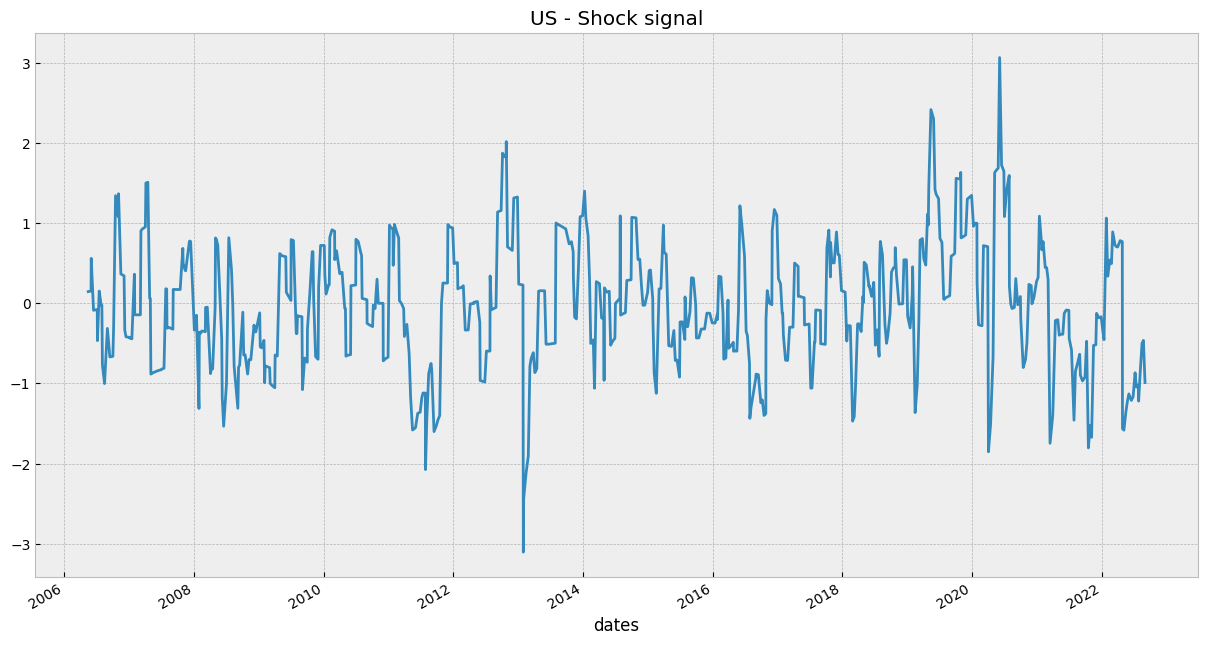

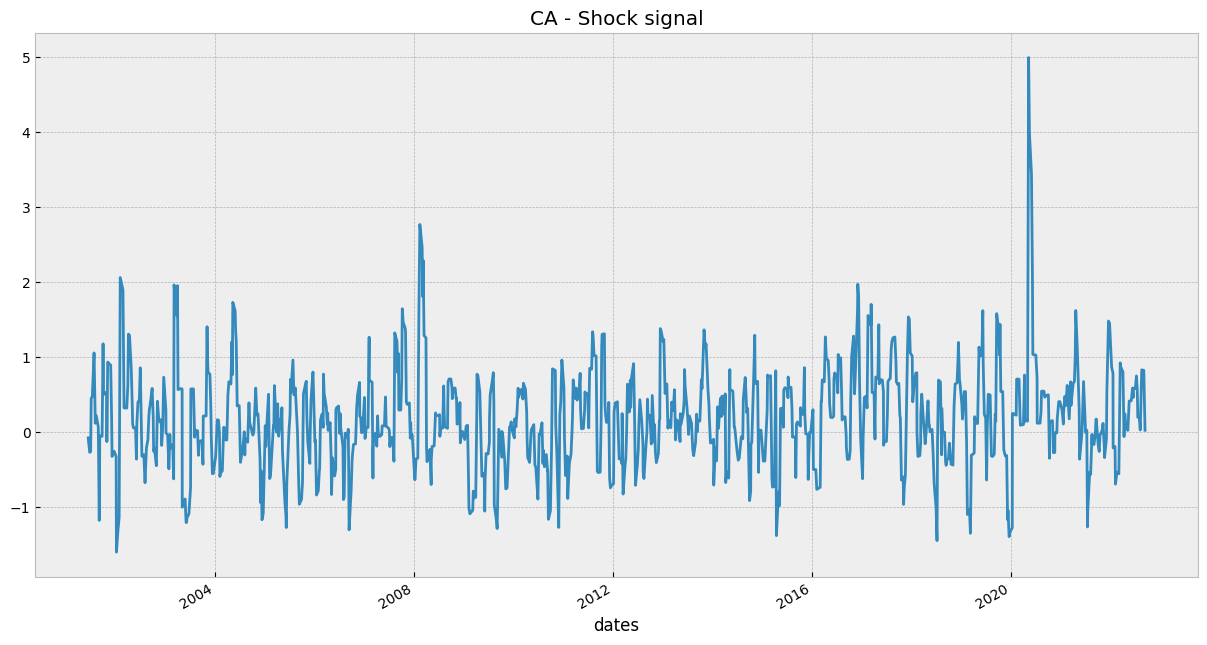

In [27]:
for country, country_shock in shocks_agg.items():
    country_shock.plot(label=country)
    plt.title(f"{country} - Shock signal")
    plt.show()

## Create Signal

We use the raw indicator as the signal here. We can smoothen the signal and do a rolling window, but choosing the window is an optimization task which I have decided to omit form this analysis.

In [46]:
def create_shock_signal(ts):
    """
    Scale so that the signal is between 1 and -1.
    Keep the same distribution.
    """
    # ts is a vector
    signal = pd.DataFrame(np.zeros((len(ts.index), 1)),index=ts.index, columns=['signal'])

    signal['signal'] = ts / ts.rolling(window=40).max()
    
    return signal

In [47]:
# Use raw signal 
ca_shock_sgnl = create_shock_signal(shocks_agg['CA'])
us_shock_sgnl = create_shock_signal(shocks_agg['US'])

## Test signal performance

In [48]:
# Resample the Signal into daily signal
ca_daily_shock_pos = ca_shock_sgnl.resample('D').ffill()
us_daily_shock_pos = us_shock_sgnl.resample('D').ffill()

In [49]:
us_pnl = calculate_pnl(us_returns, us_daily_shock_pos['signal'])
ca_pnl = calculate_pnl(ca_returns, ca_daily_shock_pos['signal'])

<Axes: title={'center': 'Cumulative Trading Profit - Shock Indicator'}, xlabel='dates'>

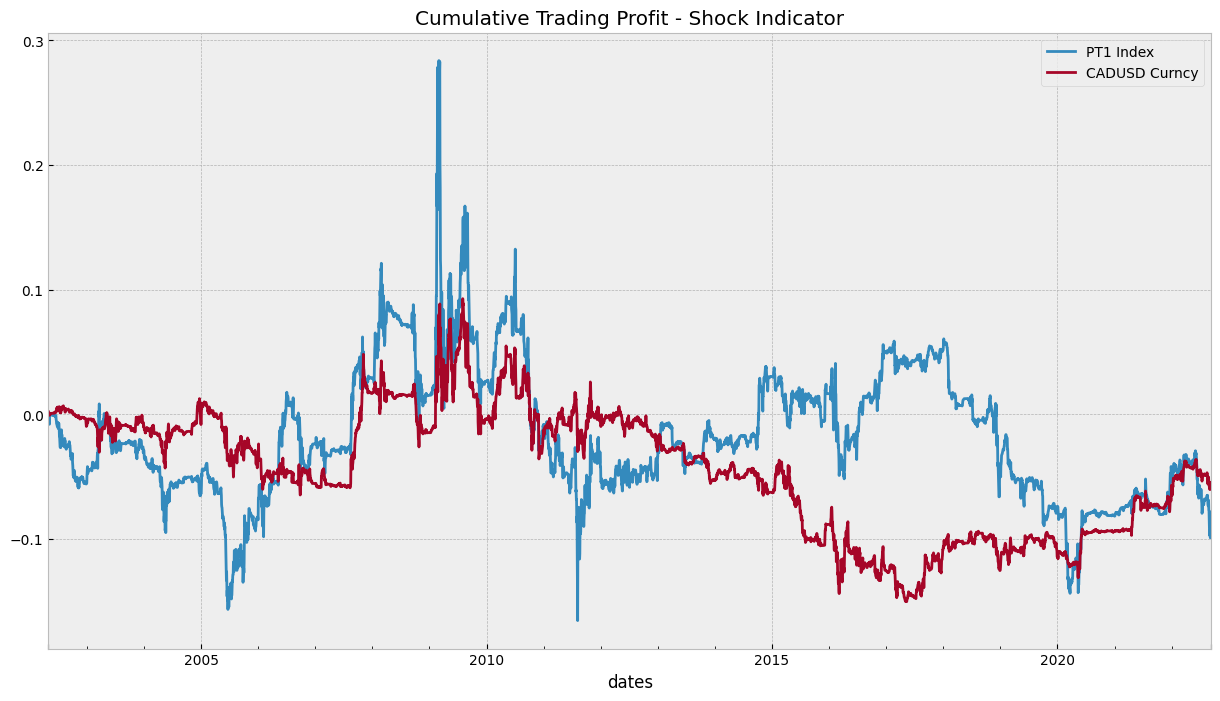

In [51]:
ca_pnl.cumsum().plot(title='Cumulative Trading Profit - Shock Indicator')

<Axes: title={'center': 'Cumulative Trading Profit - Shock Indicator'}, xlabel='dates'>

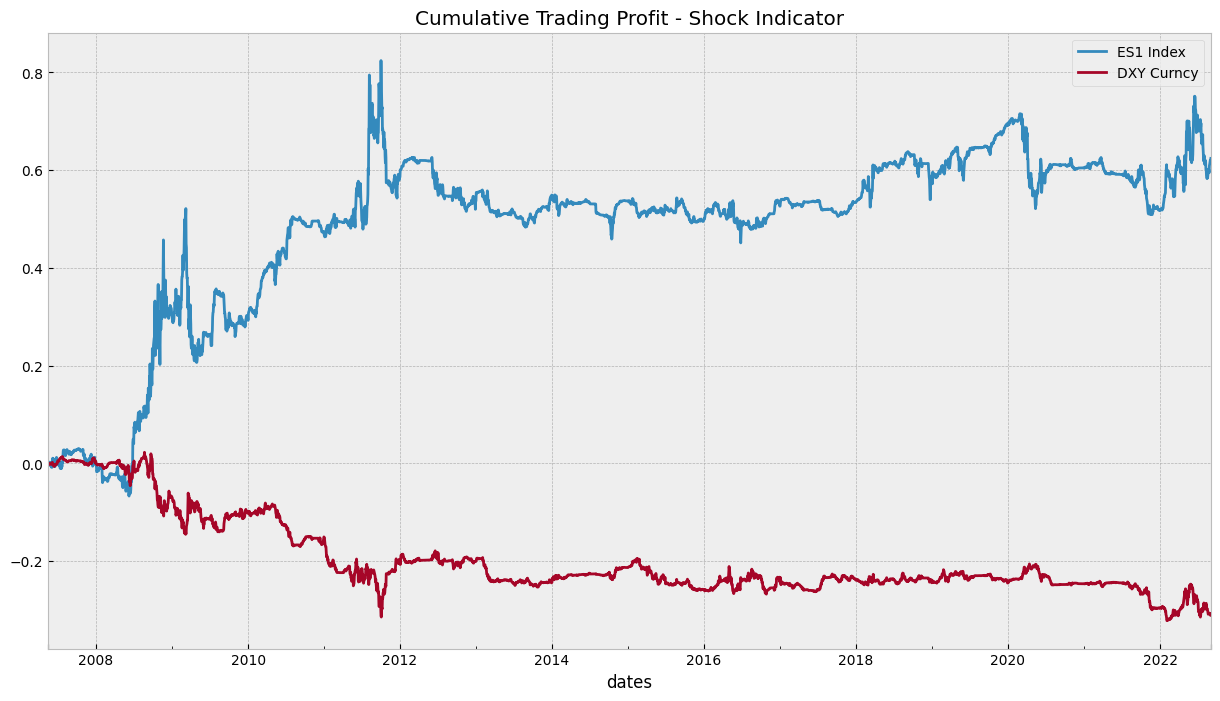

In [52]:
us_pnl.cumsum().plot(title='Cumulative Trading Profit - Shock Indicator')

## Analysis

Q: How does the signal perform across given assets?
* The `shock` indicator performs well for the ES1 index & PT1, specially during the 2005-2010 period. 
* It performs poorly for both the currencies.
* This might be a strong contender to be an additive signal to the momentum signal that was given as example.

Q: Why did this signal not work?
* A positive `shock` doesn't isn't always a positive indication for the economy. Recently, due to higher inflation, one would want to see a slowdown in metrics like "Home Sales". A positve shock in this case will be considered as a negative outcome for the economy. 
* Equally-weighting the 4 indicators shock levels can also hurt performance. As we noted before, for both the countries, we notice that different indicators have different volatilities. Some indicators might be more indicative of the financial market performance than the others. Exploring these avenues will help us make the economic indicator better and maybe even use this indicator as signals.
* As mentioned before, expected values are calculated by humans which leads to multiple sources of uncertainity. 